In [ ]:
pipeline_dataset = Pipeline(
   steps=[
        LoadDataFrameStep(path="df_intermedio.parquet"),
        FilterProductsIDStep(dfs=["df"]), # hago este aca para que el dataset sea mas chico y pueda correrlo en local
        #FilterProductForTestingStep(total_products_ids=10, random=False), # filtro para que sea mas chico el dataset
        ScaleFeatureStep(
            column="tn",
            scaler=CustomStandarScaler,
        ),
        ScaleFeatureStep(
            column="cust_request_qty",
            scaler=CustomStandarScaler,
            save=False,
        ),
        ScaleFeatureStep(
            column="cust_request_tn",
            scaler=CustomStandarScaler,
            save=False,
        ),
        CreateSerieIdStep(),
        DateRelatedFeaturesStep(),
        CastDataTypesStep(dtypes=
            {
                "product_id": "uint32", 
                "customer_id": "uint32",
                "mes": "uint16",
                "year": "uint16",
                "brand": "category",
                "cat1": "category",
                "cat2": "category",
                "cat3": "category",
            }
        ),
        #DropMinSerieMonthStep(months=3),  # filtro para que las series tengan al menos 3 meses
        #CreateTargetColumStep(target_col="tn_scaled"),

        FeatureEngineeringLagStep(lags=[1,2,3,5,11], columns=["tn_scaled", "cust_request_qty"]),
        RollingMeanFeatureStep(window=3, columns=["tn_scaled", "cust_request_qty"]),
        RollingMaxFeatureStep(window=3, columns=["tn_scaled", "cust_request_qty"]),
        RollingMinFeatureStep(window=3, columns=["tn_scaled", "cust_request_qty"]),
        ChangeDataTypesStep(dtypes={
            "float64": "float32",
        }),
        DiffFeatureStep(periods=1, columns=["tn_scaled", "cust_request_qty"]),
        DiffFeatureStep(periods=2, columns=["tn_scaled", "cust_request_qty"]),
        DiffFeatureStep(periods=5, columns=["tn_scaled", "cust_request_qty"]),
        DiffFeatureStep(periods=11, columns=["tn_scaled", "cust_request_qty"]),
        #FeatureEngineeringProductCatInteractionStep(cat="cat1").in_disk_cache(),
        ChangeDataTypesStep(dtypes={
            "float64": "float32",
        }),
        CreateTotalCategoryStep(cat="cat1"),
        CreateTotalCategoryStep(cat="cat2"),
        CreateTotalCategoryStep(cat="cat3"),
        CreateTotalCategoryStep(cat="brand"),
        ChangeDataTypesStep(dtypes={
            "float64": "float32",
        }),
        CreateTotalCategoryStep(cat="cat1", tn="tn_scaled"),
        CreateTotalCategoryStep(cat="cat2", tn="tn_scaled"),
        CreateTotalCategoryStep(cat="cat3", tn="tn_scaled"),
        CreateTotalCategoryStep(cat="brand", tn="tn_scaled"),
        CreateTotalCategoryStep(cat="customer_id", tn="tn_scaled"),
        CreateTotalCategoryStep(cat="product_id", tn="tn_scaled"),

        ChangeDataTypesStep(dtypes={
            "float64": "float32",
        }),

        FeatureDivInteractionStep(columns=[
            ("tn", "tn_cat1_vendidas"), 
            ("tn", "tn_cat2_vendidas"), 
            ("tn", "tn_cat3_vendidas"), 
            ("tn", "tn_brand_vendidas")]
        ),
        ChangeDataTypesStep(dtypes={
            "float64": "float32",
        }),
        FeatureProdInteractionStep(columns=[("tn_scaled", "cust_request_qty")]),
        CreateWeightByCustomerStep(),
        ChangeDataTypesStep(dtypes={
            "float64": "float32",
        }),
        CreateWeightByProductStep(),
        ChangeDataTypesStep(dtypes={
            "float64": "float32",
        }),
        SaveDataFrameStep(
            df_name="df", 
            file_name="df_fe", 
            ext="parquet"
        ),
        SaveScalerStep(
            scaler_name="custom_scaler", 
            file_name="custom_scaler",
        ),
   ] 
)

In [32]:
import datetime
pipeline_training = Pipeline(
    steps=[
        LoadDataFrameStep(path="df_fe.parquet"),
        LoadScalerStep(artifact_name="custom_scaler", file_name="custom_scaler"),
        CreateTargetColumStep(target_col="tn_scaled"),
        #CreateTargetColumDiffStep(target_col="tn_scaled"),
        FilterProductsIDStep(dfs=["df"]),

        # filtro por fecha para achicar el dataset en local
        FilterFirstDateStep(first_date="2017-06"),
        ChangeDataTypesStep(dtypes={
            "float64": "float32",
        }),
        SplitDataFrameStep(),
        FilterProductsIDStep(dfs=["test", "eval_data", "kaggle_pred"]),
        PrepareXYStep(),
        TrainModelLGBStep(
            train_eval_sets={
                "X_train": "X_train",
                "y_train": "y_train",
                "X_eval": "X_eval",
                "y_eval": "y_eval",
                "eval_data": "eval_data"
            },
        ),
        PredictStep(predict_set="X_test"),
        #IntegratePredictionsStep(),
        InverseScalePredictionsStep(),
        EvaluatePredictionsSteps(y_actual_df="y_test_unscale"),
        PlotFeatureImportanceStep(),
        TrainModelLGBStep(
            train_eval_sets={
               "X_train": "X_train_final",
               "y_train": "y_train_final",
                "X_eval": "X_test",
                "y_eval": "y_test",
                "eval_data": "test",
            },
        ),
        PredictStep(predict_set="X_kaggle"),
        #IntegratePredictionsStep(),
        InverseScalePredictionsStep(),
        KaggleSubmissionStep(), # falta hacer la inversa de la prediccion
        SaveExperimentStep(exp_name=f"{datetime.datetime.now().strftime('%Y%m%d_%H%M')}_exp_lgb_scaled_target_diff_con_fe", save_dataframes=False),

    ],
        optimize_arftifacts_memory=True
)
    

In [33]:
pipeline_dataset.run(verbose=True)
del pipeline_dataset
import gc
gc.collect()
#pipeline_training.run(verbose=True)

Executing step: LoadDataFrameStep
Step LoadDataFrameStep completed in 2.24 seconds
Executing step: FilterProductsIDStep
Filtered DataFrame df shape: (11101445, 13)
Step FilterProductsIDStep completed in 2.56 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 2.84 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 2.93 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 2.97 seconds
Executing step: CreateSerieIdStep
Step CreateSerieIdStep completed in 8.02 seconds
Executing step: DateRelatedFeaturesStep
Step DateRelatedFeaturesStep completed in 3.00 seconds
Executing step: CastDataTypesStep
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11101445 entries, 0 to 11101444
Data columns (total 19 columns):
 #   Column                   Dtype    
---  ------                   -----    
 0   product_id               uint32   
 1   fecha                    period[M]
 2   customer_id              uint32   
 3   plan_prec

0

In [23]:
# obtengo los products_ids que aportan el 80% del total de error_absoluto
eval_df = pipeline_training.get_artifact("eval_df")
top_products = eval_df.sort_values("error_absoluto", ascending=False)
top_products = top_products.head(int(len(top_products) * 0.2))
print(top_products.to_string())

   product_id      tn_real      tn_pred  error_absoluto
7       20008   195.368541   465.261545      269.893004
0       20001  1504.688553  1405.503484       99.185069


/tmp/ipykernel_217875/1041069711.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_df = df[df["product_id"]==20008][df["customer_id"]==10030]


<Axes: title={'center': 'tn vs tn_scaled vs target'}>

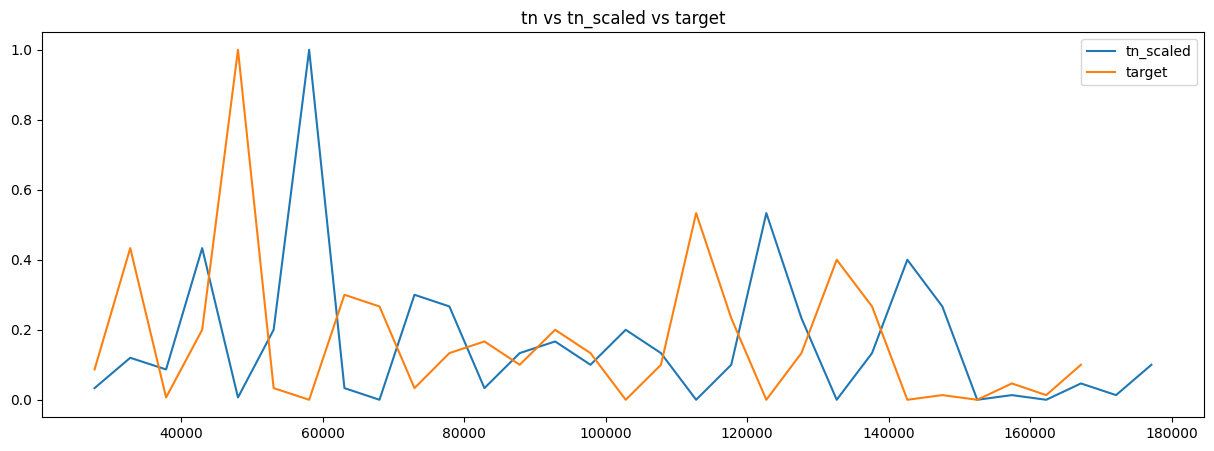

In [28]:
df = pipeline_training.get_artifact("df")
sub_df = df[df["product_id"]==20008][df["customer_id"]==10030]
sub_df[["tn_scaled", "target"]].plot(figsize=(15, 5), title="tn vs tn_scaled vs target")


In [21]:
sub_df[["tn_scaled", "target"]]

,tn_scaled,target
1216825,0.872881,-0.685026
1475883,0.375336,-0.410055
1740511,0.187855,-0.144216
2009772,-0.034719,-0.411977
2283619,0.043639,-0.411016
2560315,-0.446696,-0.490335
2844550,-0.367377,-0.317275
3127093,-0.937031,0.728291
3409929,-0.684652,0.439859
3691022,-0.208739,0.237476


### notas
- Con MinMax escaler dio bien en test pero mal el kaggle, esto es porque se esta escalando con todos los datos y al reescalar va a predecir mal valores que no estan entre 0 y 1
- Cuando pruebo el model con solo 1 producto me da muy bajo el error, estara mal entrenar 780 modelos 1 para cada producto?
- xgboost usa mucha memoria como para entrenarlo local